# Experiments

## K vs Number of Rounds for the classic protocol 

Starting experiment. Logs will be saved to tpm_logs_20250930_161524

Running for K=3 (30 repetitions):
 Repetition 1/30... done in 399 rounds.
 Repetition 2/30... done in 349 rounds.
 Repetition 3/30... done in 502 rounds.
 Repetition 4/30... done in 468 rounds.
 Repetition 5/30... done in 436 rounds.
 Repetition 6/30... done in 477 rounds.
 Repetition 7/30... done in 318 rounds.
 Repetition 8/30... done in 431 rounds.
 Repetition 9/30... done in 480 rounds.
 Repetition 10/30... done in 455 rounds.
 Repetition 11/30... done in 384 rounds.
 Repetition 12/30... done in 294 rounds.
 Repetition 13/30... done in 600 rounds.
 Repetition 14/30... done in 350 rounds.
 Repetition 15/30... done in 559 rounds.
 Repetition 16/30... done in 407 rounds.
 Repetition 17/30... done in 351 rounds.
 Repetition 18/30... done in 432 rounds.
 Repetition 19/30... done in 325 rounds.
 Repetition 20/30... done in 330 rounds.
 Repetition 21/30... done in 471 rounds.
 Repetition 22/30... done in 329 rounds.
 Rep

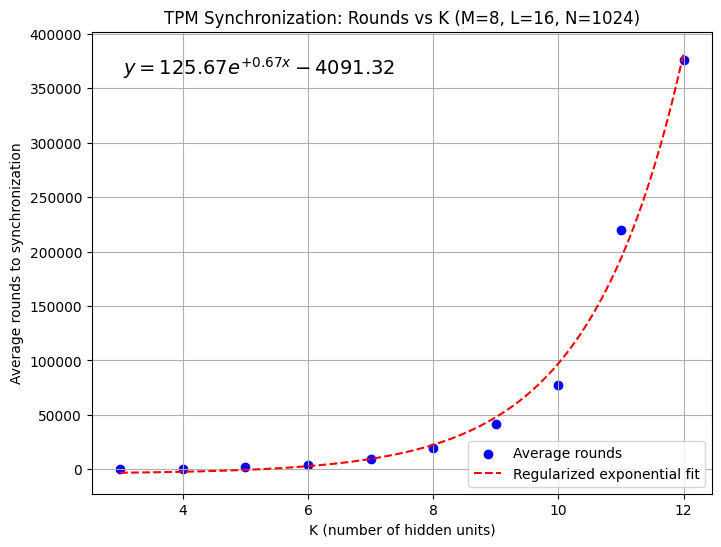


Regularized exponential fit equation: $y = 125.67e^{+0.67x} - 4091.32$
RMSE: 10769.34
Results and plot saved in tpm_logs_20250930_161524
Regularization strength (lambda_reg): 1.0


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum_vec(x, sender=True):
    res = np.where(x > 0, 1, np.where(x < 0, -1, 1 if sender else -1))
    return res

def tpm_output(X, W, sender=True):
    s = np.sum(X * W, axis=1)
    y = signum_vec(s, sender)
    O = np.prod(y)
    return O, y

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        mask = (y == O)
        update = np.zeros_like(W)
        update[mask] = O * X[mask]
        W_new = W + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W

def is_synchronized(W1, W2):
    return np.array_equal(W1, W2)

def tpm_key_agreement(K, N, L, M, max_iter=100000, verbose=False):
    W_A = initialize_weights(K, N, L)
    W_B = initialize_weights(K, N, L)
    steps = 0

    while not is_synchronized(W_A, W_B) and steps < max_iter:
        X = generate_input_vector(K, N, M)
        O_A, y_A = tpm_output(X, W_A, sender=True)
        O_B, y_B = tpm_output(X, W_B, sender=False)
        W_A = hebbian_update(W_A, X, y_A, O_A, O_B, L)
        W_B = hebbian_update(W_B, X, y_B, O_B, O_A, L)
        steps += 1
    return W_A, W_B, steps

def format_exp_equation(a, b, c):
    """Formats the exponential equation with correct signs."""
    def fmt(x):
        return f"{abs(x):.2f}"

    # a term
    a_str = f"{fmt(a)}" if a >= 0 else f"-{fmt(a)}"
    # b term (in exponent)
    b_sign = "+" if b >= 0 else "-"
    b_str = f"{fmt(b)}"
    # c term
    if c == 0:
        c_str = ""
    elif c > 0:
        c_str = f" + {fmt(c)}"
    else:
        c_str = f" - {fmt(c)}"

    eq = f"$y = {a_str}e^{{{b_sign}{b_str}x}}{c_str}$"
    return eq

def run_experiment():
    M = 8
    L = 16
    N = 1024
    K_values = list(range(3, 13))
    reps = 30
    max_iter = 1000000

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"tpm_logs_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, "experiment_log.json")
    plot_file = os.path.join(log_dir, "rounds_vs_K_exponential_fit_regularized.png")

    results = {}
    print(f"Starting experiment. Logs will be saved to {log_dir}")

    for K in K_values:
        rounds_list = []
        print(f"\nRunning for K={K} ({reps} repetitions):")
        for rep in range(1, reps+1):
            print(f" Repetition {rep}/{reps}...", end="", flush=True)
            _, _, steps = tpm_key_agreement(K, N, L, M, max_iter=max_iter, verbose=False)
            rounds_list.append(steps)
            print(f" done in {steps} rounds.")
        avg_rounds = np.mean(rounds_list)
        std_rounds = np.std(rounds_list)
        results[K] = {
            "rounds": rounds_list,
            "average": float(avg_rounds),
            "std": float(std_rounds)
        }
        print(f" K={K}: Avg rounds = {avg_rounds:.2f}, Std = {std_rounds:.2f}")

        # Save intermediate results
        with open(log_file, "w") as f:
            json.dump(results, f, indent=2)

    # --- Exponential curve fitting with regularization ---
    K_list = sorted(results.keys())
    avg_list = [results[K]["average"] for K in K_list]

    K_arr = np.array(K_list)
    avg_arr = np.array(avg_list)

    # Exponential fit function
    def exponential(x, a, b, c): return a * np.exp(b * x) + c

    # Regularized loss function
    lambda_reg = 1.0  # Increase for stronger penalty on c
    def loss(params):
        a, b, c = params
        pred = exponential(K_arr, a, b, c)
        mse = np.mean((avg_arr - pred)**2)
        reg = lambda_reg * c**2
        return mse + reg

    # Initial guess: use unregularized fit as starting point
    from scipy.optimize import curve_fit
    popt0, _ = curve_fit(exponential, K_arr, avg_arr, maxfev=10000)
    res = minimize(loss, popt0, method='L-BFGS-B')
    a, b, c = res.x

    # Compute predictions and RMSE
    pred = exponential(K_arr, a, b, c)
    rmse = np.sqrt(mean_squared_error(avg_arr, pred))

    # Prepare LaTeX equation with correct sign formatting
    eq_latex = format_exp_equation(a, b, c)

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(K_list, avg_list, color='blue', label="Average rounds")
    K_fit = np.linspace(min(K_list), max(K_list), 100)
    plt.plot(K_fit, exponential(K_fit, a, b, c), 'r--', label="Regularized exponential fit")
    plt.xlabel("K (number of hidden units)")
    plt.ylabel("Average rounds to synchronization")
    plt.title(f"TPM Synchronization: Rounds vs K (M={M}, L={L}, N={N})")
    plt.legend()
    plt.grid(True)
    plt.text(0.05, 0.95, eq_latex, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.savefig(plot_file)
    plt.show()

    print(f"\nRegularized exponential fit equation: {eq_latex}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Results and plot saved in {log_dir}")
    print(f"Regularization strength (lambda_reg): {lambda_reg}")

if __name__ == "__main__":
    run_experiment()


## L vs Number of Rounds for the classic protocol

Starting experiment. Logs will be saved to tpm_logs_L_20250930_165442

Running for L=16 (50 repetitions):
 Repetition 1/50...

 done in 290 rounds.
 Repetition 2/50... done in 475 rounds.
 Repetition 3/50... done in 645 rounds.
 Repetition 4/50... done in 484 rounds.
 Repetition 5/50... done in 522 rounds.
 Repetition 6/50... done in 522 rounds.
 Repetition 7/50... done in 598 rounds.
 Repetition 8/50... done in 318 rounds.
 Repetition 9/50... done in 369 rounds.
 Repetition 10/50... done in 390 rounds.
 Repetition 11/50... done in 322 rounds.
 Repetition 12/50... done in 585 rounds.
 Repetition 13/50... done in 423 rounds.
 Repetition 14/50... done in 522 rounds.
 Repetition 15/50... done in 510 rounds.
 Repetition 16/50... done in 376 rounds.
 Repetition 17/50... done in 448 rounds.
 Repetition 18/50... done in 322 rounds.
 Repetition 19/50... done in 380 rounds.
 Repetition 20/50... done in 408 rounds.
 Repetition 21/50... done in 653 rounds.
 Repetition 22/50... done in 358 rounds.
 Repetition 23/50... done in 434 rounds.
 Repetition 24/50... done in 539 rounds.
 Repetition 25/50... done in 397 rounds.
 Re

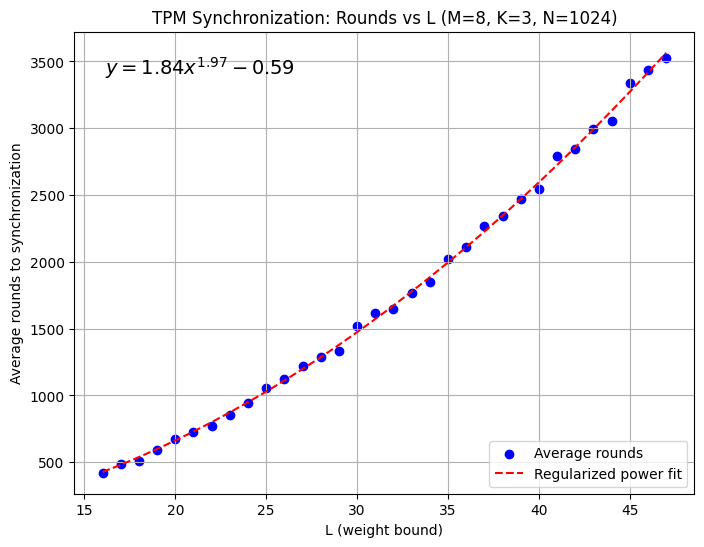


Regularized power fit equation: $y = 1.84x^{1.97} - 0.59$
RMSE: 31.77
Results and plot saved in tpm_logs_L_20250930_165442
Regularization strength (lambda_reg): 1.0


In [88]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
from scipy.optimize import minimize, curve_fit
from sklearn.metrics import mean_squared_error

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum_vec(x, sender=True):
    res = np.where(x > 0, 1, np.where(x < 0, -1, 1 if sender else -1))
    return res

def tpm_output(X, W, sender=True):
    s = np.sum(X * W, axis=1)
    y = signum_vec(s, sender)
    O = np.prod(y)
    return O, y

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        mask = (y == O)
        update = np.zeros_like(W)
        update[mask] = O * X[mask]
        W_new = W + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W

def is_synchronized(W1, W2):
    return np.array_equal(W1, W2)

def tpm_key_agreement(K, N, L, M, max_iter=100000, verbose=False):
    W_A = initialize_weights(K, N, L)
    W_B = initialize_weights(K, N, L)
    steps = 0

    while not is_synchronized(W_A, W_B) and steps < max_iter:
        X = generate_input_vector(K, N, M)
        O_A, y_A = tpm_output(X, W_A, sender=True)
        O_B, y_B = tpm_output(X, W_B, sender=False)
        W_A = hebbian_update(W_A, X, y_A, O_A, O_B, L)
        W_B = hebbian_update(W_B, X, y_B, O_B, O_A, L)
        steps += 1
    return W_A, W_B, steps

def format_power_equation(a, b, c):
    """Formats the power law equation with correct signs."""
    def fmt(x):
        return f"{abs(x):.2f}"

    # a term
    a_str = f"{fmt(a)}" if a >= 0 else f"-{fmt(a)}"
    # b exponent
    b_sign = "" if b >= 0 else "-"
    b_str = f"{fmt(b)}"
    # c term
    if c == 0:
        c_str = ""
    elif c > 0:
        c_str = f" + {fmt(c)}"
    else:
        c_str = f" - {fmt(c)}"

    eq = f"$y = {a_str}x^{{{b_sign}{b_str}}}{c_str}$"
    return eq

def run_experiment():
    M = 8
    K = 3
    N = 1024
    L_values = list(range(16, 48))  # 16 to 32 inclusive
    reps = 50
    max_iter = 1000000

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"tpm_logs_L_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, "experiment_log.json")
    plot_file = os.path.join(log_dir, "rounds_vs_L_power_fit_regularized.png")

    results = {}
    print(f"Starting experiment. Logs will be saved to {log_dir}")

    for L in L_values:
        rounds_list = []
        print(f"\nRunning for L={L} ({reps} repetitions):")
        for rep in range(1, reps+1):
            print(f" Repetition {rep}/{reps}...", end="", flush=True)
            _, _, steps = tpm_key_agreement(K, N, L, M, max_iter=max_iter, verbose=False)
            rounds_list.append(steps)
            print(f" done in {steps} rounds.")
        avg_rounds = np.mean(rounds_list)
        std_rounds = np.std(rounds_list)
        results[L] = {
            "rounds": rounds_list,
            "average": float(avg_rounds),
            "std": float(std_rounds)
        }
        print(f" L={L}: Avg rounds = {avg_rounds:.2f}, Std = {std_rounds:.2f}")

        # Save intermediate results
        with open(log_file, "w") as f:
            json.dump(results, f, indent=2)

    # --- Power law curve fitting with regularization ---
    L_list = sorted(results.keys())
    avg_list = [results[L]["average"] for L in L_list]

    L_arr = np.array(L_list)
    avg_arr = np.array(avg_list)

    # Power law fit function
    def powerlaw(x, a, b, c): return a * x**b + c

    # Regularized loss function
    lambda_reg = 1.0  # Increase for stronger penalty on c
    def loss(params):
        a, b, c = params
        pred = powerlaw(L_arr, a, b, c)
        mse = np.mean((avg_arr - pred)**2)
        reg = lambda_reg * c**2
        return mse + reg

    # Initial guess: use unregularized fit as starting point
    popt0, _ = curve_fit(powerlaw, L_arr, avg_arr, maxfev=10000)
    res = minimize(loss, popt0, method='L-BFGS-B')
    a, b, c = res.x

    # Compute predictions and RMSE
    pred = powerlaw(L_arr, a, b, c)
    rmse = np.sqrt(mean_squared_error(avg_arr, pred))

    # Prepare LaTeX equation with correct sign formatting
    eq_latex = format_power_equation(a, b, c)

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(L_list, avg_list, color='blue', label="Average rounds")
    L_fit = np.linspace(min(L_list), max(L_list), 200)
    plt.plot(L_fit, powerlaw(L_fit, a, b, c), 'r--', label="Regularized power fit")
    plt.xlabel("L (weight bound)")
    plt.ylabel("Average rounds to synchronization")
    plt.title(f"TPM Synchronization: Rounds vs L (M={M}, K={K}, N={N})")
    plt.legend()
    plt.grid(True)
    plt.text(0.05, 0.95, eq_latex, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.savefig(plot_file)
    plt.show()

    print(f"\nRegularized power fit equation: {eq_latex}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Results and plot saved in {log_dir}")
    print(f"Regularization strength (lambda_reg): {lambda_reg}")

if __name__ == "__main__":
    run_experiment()


## K vs Number of Rounds for our protocol 

Starting experiment. Logs will be saved to tpm_logs_K_20250930_161118

Running for K=3 (50 repetitions):
 Repetition 1/50... done in 70 rounds.
 Repetition 2/50... done in 104 rounds.
 Repetition 3/50... done in 47 rounds.
 Repetition 4/50... done in 37 rounds.
 Repetition 5/50... done in 52 rounds.
 Repetition 6/50... done in 106 rounds.
 Repetition 7/50... done in 56 rounds.
 Repetition 8/50... done in 50 rounds.
 Repetition 9/50... done in 33 rounds.
 Repetition 10/50... done in 79 rounds.
 Repetition 11/50... done in 68 rounds.
 Repetition 12/50... done in 43 rounds.
 Repetition 13/50... done in 56 rounds.
 Repetition 14/50... done in 47 rounds.
 Repetition 15/50... done in 19 rounds.
 Repetition 16/50... done in 87 rounds.
 Repetition 17/50... done in 75 rounds.
 Repetition 18/50... done in 50 rounds.
 Repetition 19/50... done in 39 rounds.
 Repetition 20/50... done in 45 rounds.
 Repetition 21/50... done in 29 rounds.
 Repetition 22/50... done in 84 rounds.
 Repetition 23/50... d

/tmp/ipykernel_168530/3340547907.py:180: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/tmp/ipykernel_168530/3340547907.py:180: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


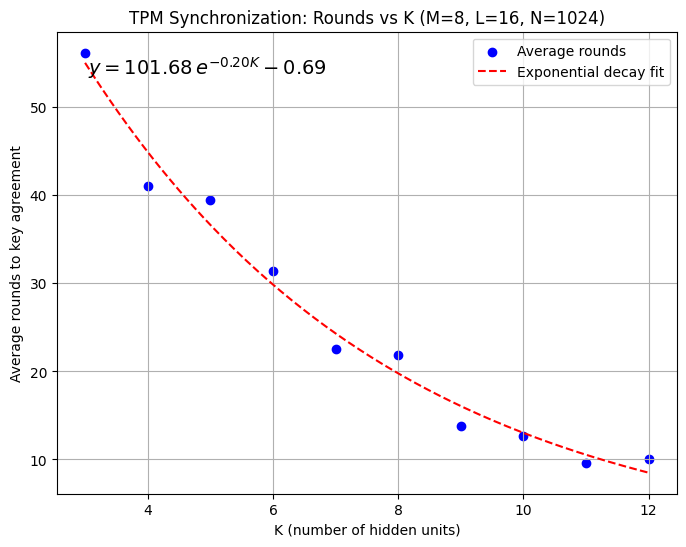


Exponential decay fit equation: $y = 101.68\,e^{-0.20 K} - 0.69$
RMSE: 2.05
Results and plot saved in tpm_logs_K_20250930_161118


In [86]:
import numpy as np
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

# --- TPM protocol functions (attack part ignored) ---

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum(x, sender=True):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 1 if sender else -1

def tpm_output(X, W, sender=True):
    K, N = X.shape
    y = np.zeros(K, dtype=int)
    for k in range(K):
        s = np.dot(X[k], W[k])
        y[k] = signum(s, sender)
    O = np.prod(y)
    return O, y

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        K, N = W.shape
        for k in range(K):
            if y[k] == O:
                for n in range(N):
                    W[k, n] += O * X[k, n]
                    W[k, n] = np.clip(W[k, n], -L, L)
    return W

def flatten_weights(W):
    return W.flatten()

def protocol_verification(
    alice_weights, bob_weights, L, max_key_length=128, 
    extreme_threshold=None, min_consistent_threshold=3, 
    consistent_counts=None, rng=None
):
    N_total = alice_weights.size
    rng = rng or np.random.default_rng()
    weights1 = flatten_weights(alice_weights)
    weights2 = rng.integers(-L, L+1, size=N_total)
    swap_mask = rng.integers(0, 2, size=N_total, dtype=bool)
    alice_real_mask = ~swap_mask
    weights1_swapped = np.where(swap_mask, weights2, weights1)
    weights2_swapped = np.where(swap_mask, weights1, weights2)
    weights3 = flatten_weights(bob_weights)
    private_mask = (weights3 == weights1_swapped) | (weights3 == weights2_swapped)
    if extreme_threshold is None:
        extreme_threshold = L
    real_positions = np.where(alice_real_mask)[0]
    not_extreme = np.abs(weights1[real_positions]) < extreme_threshold
    candidate_positions = real_positions[not_extreme]
    valid_positions = candidate_positions[private_mask[candidate_positions]]

    # --- Consistency check with reset on mismatch ---
    if consistent_counts is None:
        consistent_counts = np.zeros(N_total, dtype=int)
    # Increment where match, reset to zero where not match
    consistent_counts[private_mask] += 1
    consistent_counts[~private_mask] = 0
    consistent_positions = np.where(consistent_counts >= min_consistent_threshold)[0]
    # ------------------------------------------------

    final_positions = [i for i in valid_positions if i in consistent_positions]
    if len(final_positions) > max_key_length:
        final_positions = final_positions[:max_key_length]
    alice_key = weights1[final_positions]
    bob_key = weights3[final_positions]
    return alice_key, bob_key, final_positions, consistent_counts

def tpm_key_agreement(
    K, N, L, M, T=1, max_key_length=16, min_consistent_threshold=4, 
    extreme_threshold=None, max_iter=100000, verbose=False
):
    rng = np.random.default_rng()
    W_A = initialize_weights(K, N, L)
    W_B = initialize_weights(K, N, L)
    steps = 0
    consistent_counts = np.zeros(K*N, dtype=int)
    alice_key = bob_key = None
    key_found = False
    final_positions = []

    while steps < max_iter and not key_found:
        X = generate_input_vector(K, N, M)
        O_A, y_A = tpm_output(X, W_A, sender=True)
        O_B, y_B = tpm_output(X, W_B, sender=False)
        W_A = hebbian_update(W_A, X, y_A, O_A, O_B, L)
        W_B = hebbian_update(W_B, X, y_B, O_B, O_A, L)
        steps += 1
        if steps % T == 0:
            alice_key, bob_key, final_positions, consistent_counts = protocol_verification(
                W_A, W_B, L, max_key_length, extreme_threshold, min_consistent_threshold, consistent_counts, rng
            )
            if verbose:
                print(f"Step {steps}: Key length so far: {len(alice_key)}")
            if len(alice_key) >= max_key_length:
                key_found = True

                

    return alice_key, bob_key, steps

# --- Experiment and plotting ---

def log_fit(x, a, b, c):
    return a * np.log(x) + b * x + c

def run_experiment():
    M = 8
    L = 16
    N = 1024
    K_values = list(range(3, 13))  # 3 to 12 inclusive
    reps = 50
    max_key_length = 128
    min_consistent_threshold = 4
    max_iter = 1000000

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"tpm_logs_K_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, "experiment_log.json")
    plot_file = os.path.join(log_dir, "rounds_vs_K_log_fit.png")

    results = {}
    print(f"Starting experiment. Logs will be saved to {log_dir}")

    for K in K_values:
        rounds_list = []
        print(f"\nRunning for K={K} ({reps} repetitions):")
        for rep in range(1, reps+1):
            print(f" Repetition {rep}/{reps}...", end="", flush=True)
            _, _, steps = tpm_key_agreement(
                K, N, L, M, 
                max_key_length=max_key_length, 
                min_consistent_threshold=min_consistent_threshold, 
                max_iter=max_iter, 
                verbose=False
            )
            rounds_list.append(steps)
            print(f" done in {steps} rounds.")
        avg_rounds = np.mean(rounds_list)
        std_rounds = np.std(rounds_list)
        results[K] = {
            "rounds": rounds_list,
            "average": float(avg_rounds),
            "std": float(std_rounds)
        }
        print(f" K={K}: Avg rounds = {avg_rounds:.2f}, Std = {std_rounds:.2f}")

        # Save intermediate results
        with open(log_file, "w") as f:
            json.dump(results, f, indent=2)

   
    # --- Exponential decay curve fitting (y = a * exp(-b*K) + c) ---
    K_list = sorted(results.keys())
    avg_list = [results[K]["average"] for K in K_list]

    K_arr = np.array(K_list)
    avg_arr = np.array(avg_list)

    # Exponential decay fit function: a * exp(-b * K) + c
    def exp_decay_func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, _ = curve_fit(exp_decay_func, K_arr, avg_arr, maxfev=10000)
    a, b, c = popt

    # Compute predictions and RMSE
    pred = exp_decay_func(K_arr, a, b, c)
    rmse = np.sqrt(mean_squared_error(avg_arr, pred))

    # Prepare LaTeX equation
    def format_exp_decay_equation(a, b, c):
        return r"$y = %.2f\,e^{-%.2f K} %s %.2f$" % (
            a, b, "+" if c >= 0 else "-", abs(c)
        )

    eq_latex = format_exp_decay_equation(a, b, c)

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(K_list, avg_list, color='blue', label="Average rounds")
    K_fit = np.linspace(min(K_list), max(K_list), 200)
    plt.plot(K_fit, exp_decay_func(K_fit, a, b, c), 'r--', label="Exponential decay fit")
    plt.xlabel("K (number of hidden units)")
    plt.ylabel("Average rounds to key agreement")
    plt.title(f"TPM Synchronization: Rounds vs K (M={M}, L={L}, N={N})")
    plt.legend()
    plt.grid(True)
    plt.text(0.05, 0.95, eq_latex, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.savefig(plot_file)
    plt.show()

    print(f"\nExponential decay fit equation: {eq_latex}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Results and plot saved in {log_dir}")




   

if __name__ == "__main__":
    run_experiment()


## L vs Number of Rounds for our protocol

Starting experiment. Logs will be saved to tpm_logs_L_20250930_165740

Running for L=16 (30 repetitions):
 Repetition 1/30... done in 69 rounds.
 Repetition 2/30... done in 102 rounds.
 Repetition 3/30... done in 26 rounds.
 Repetition 4/30... done in 67 rounds.
 Repetition 5/30... done in 117 rounds.
 Repetition 6/30... done in 27 rounds.
 Repetition 7/30... done in 91 rounds.
 Repetition 8/30... done in 85 rounds.
 Repetition 9/30... done in 46 rounds.
 Repetition 10/30... done in 39 rounds.
 Repetition 11/30... done in 69 rounds.
 Repetition 12/30... done in 83 rounds.
 Repetition 13/30... done in 67 rounds.
 Repetition 14/30... done in 49 rounds.
 Repetition 15/30... done in 39 rounds.
 Repetition 16/30... done in 26 rounds.
 Repetition 17/30... done in 67 rounds.
 Repetition 18/30... done in 65 rounds.
 Repetition 19/30... done in 62 rounds.
 Repetition 20/30... done in 85 rounds.
 Repetition 21/30... done in 79 rounds.
 Repetition 22/30... done in 49 rounds.
 Repetition 23/30... 

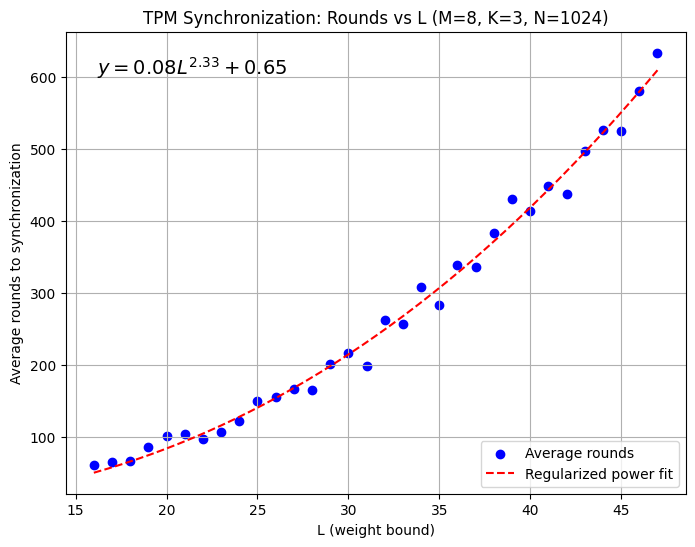


Regularized power fit equation: $y = 0.08 L^{2.33} + 0.65$
RMSE: 15.48
Results and plot saved in tpm_logs_L_20250930_165740
Regularization strength (lambda_reg): 1.0


In [89]:
import numpy as np
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from sklearn.metrics import mean_squared_error

# --- TPM protocol functions (attack part ignored) ---

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum(x, sender=True):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 1 if sender else -1

def tpm_output(X, W, sender=True):
    K, N = X.shape
    y = np.zeros(K, dtype=int)
    for k in range(K):
        s = np.dot(X[k], W[k])
        y[k] = signum(s, sender)
    O = np.prod(y)
    return O, y

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        K, N = W.shape
        for k in range(K):
            if y[k] == O:
                for n in range(N):
                    W[k, n] += O * X[k, n]
                    W[k, n] = np.clip(W[k, n], -L, L)
    return W

def flatten_weights(W):
    return W.flatten()

def protocol_verification(
    alice_weights, bob_weights, L, max_key_length=128, 
    extreme_threshold=None, min_consistent_threshold=3, 
    consistent_counts=None, rng=None
):
    N_total = alice_weights.size
    rng = rng or np.random.default_rng()
    weights1 = flatten_weights(alice_weights)
    weights2 = rng.integers(-L, L+1, size=N_total)
    swap_mask = rng.integers(0, 2, size=N_total, dtype=bool)
    alice_real_mask = ~swap_mask
    weights1_swapped = np.where(swap_mask, weights2, weights1)
    weights2_swapped = np.where(swap_mask, weights1, weights2)
    weights3 = flatten_weights(bob_weights)
    private_mask = (weights3 == weights1_swapped) | (weights3 == weights2_swapped)
    if extreme_threshold is None:
        extreme_threshold = L
    real_positions = np.where(alice_real_mask)[0]
    not_extreme = np.abs(weights1[real_positions]) < extreme_threshold
    candidate_positions = real_positions[not_extreme]
    valid_positions = candidate_positions[private_mask[candidate_positions]]

    # --- Consistency check with reset on mismatch ---
    if consistent_counts is None:
        consistent_counts = np.zeros(N_total, dtype=int)
    # Increment where match, reset to zero where not match
    consistent_counts[private_mask] += 1
    consistent_counts[~private_mask] = 0
    consistent_positions = np.where(consistent_counts >= min_consistent_threshold)[0]
    # ------------------------------------------------

    final_positions = [i for i in valid_positions if i in consistent_positions]
    if len(final_positions) > max_key_length:
        final_positions = final_positions[:max_key_length]
    alice_key = weights1[final_positions]
    bob_key = weights3[final_positions]
    return alice_key, bob_key, final_positions, consistent_counts

def tpm_key_agreement(
    K, N, L, M, T=1, max_key_length=16, min_consistent_threshold=4, 
    extreme_threshold=None, max_iter=100000, verbose=False
):
    rng = np.random.default_rng()
    W_A = initialize_weights(K, N, L)
    W_B = initialize_weights(K, N, L)
    steps = 0
    consistent_counts = np.zeros(K*N, dtype=int)
    alice_key = bob_key = None
    key_found = False
    final_positions = []

    while steps < max_iter and not key_found:
        X = generate_input_vector(K, N, M)
        O_A, y_A = tpm_output(X, W_A, sender=True)
        O_B, y_B = tpm_output(X, W_B, sender=False)
        W_A = hebbian_update(W_A, X, y_A, O_A, O_B, L)
        W_B = hebbian_update(W_B, X, y_B, O_B, O_A, L)
        steps += 1
        if steps % T == 0:
            alice_key, bob_key, final_positions, consistent_counts = protocol_verification(
                W_A, W_B, L, max_key_length, extreme_threshold, min_consistent_threshold, consistent_counts, rng
            )
            if verbose:
                print(f"Step {steps}: Key length so far: {len(alice_key)}")
            if len(alice_key) >= max_key_length:
                key_found = True

    return alice_key, bob_key, steps

# --- Experiment and plotting ---

def run_experiment():
    M = 8
    K = 3
    N = 1024
    L_values = list(range(16, 48))  # 16 to 47 inclusive
    reps = 30
    max_key_length = 128
    min_consistent_threshold = 4
    max_iter = 1000000

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"tpm_logs_L_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, "experiment_log.json")
    plot_file = os.path.join(log_dir, "rounds_vs_L_power_fit_regularized.png")

    results = {}
    print(f"Starting experiment. Logs will be saved to {log_dir}")

    for L in L_values:
        rounds_list = []
        print(f"\nRunning for L={L} ({reps} repetitions):")
        for rep in range(1, reps+1):
            print(f" Repetition {rep}/{reps}...", end="", flush=True)
            _, _, steps = tpm_key_agreement(
                K, N, L, M, 
                max_key_length=max_key_length, 
                min_consistent_threshold=min_consistent_threshold, 
                max_iter=max_iter, 
                verbose=False
            )
            rounds_list.append(steps)
            print(f" done in {steps} rounds.")
        avg_rounds = np.mean(rounds_list)
        std_rounds = np.std(rounds_list)
        results[L] = {
            "rounds": rounds_list,
            "average": float(avg_rounds),
            "std": float(std_rounds)
        }
        print(f" L={L}: Avg rounds = {avg_rounds:.2f}, Std = {std_rounds:.2f}")

        # Save intermediate results
        with open(log_file, "w") as f:
            json.dump(results, f, indent=2)

    # --- Power law curve fitting with regularization ---
    L_list = sorted(results.keys())
    avg_list = [results[L]["average"] for L in L_list]

    L_arr = np.array(L_list)
    avg_arr = np.array(avg_list)

    # Power law fit function
    def powerlaw(x, a, b, c): return a * x**b + c

    # Regularized loss function
    lambda_reg = 1.0  # Increase for stronger penalty on c
    def loss(params):
        a, b, c = params
        pred = powerlaw(L_arr, a, b, c)
        mse = np.mean((avg_arr - pred)**2)
        reg = lambda_reg * c**2
        return mse + reg

    # Initial guess: use unregularized fit as starting point
    popt0, _ = curve_fit(powerlaw, L_arr, avg_arr, maxfev=10000)
    res = minimize(loss, popt0, method='L-BFGS-B')
    a, b, c = res.x

    # Compute predictions and RMSE
    pred = powerlaw(L_arr, a, b, c)
    rmse = np.sqrt(mean_squared_error(avg_arr, pred))

    # Prepare LaTeX equation with correct sign formatting
    def format_power_equation(a, b, c):
        return r"$y = %.2f L^{%.2f} %s %.2f$" % (
            a, b, "+" if c >= 0 else "-", abs(c)
        )

    eq_latex = format_power_equation(a, b, c)

    # Plot
    plt.figure(figsize=(8,6))
    plt.scatter(L_list, avg_list, color='blue', label="Average rounds")
    L_fit = np.linspace(min(L_list), max(L_list), 200)
    plt.plot(L_fit, powerlaw(L_fit, a, b, c), 'r--', label="Regularized power fit")
    plt.xlabel("L (weight bound)")
    plt.ylabel("Average rounds to synchronization")
    plt.title(f"TPM Synchronization: Rounds vs L (M={M}, K={K}, N={N})")
    plt.legend()
    plt.grid(True)
    plt.text(0.05, 0.95, eq_latex, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.savefig(plot_file)
    plt.show()

    print(f"\nRegularized power fit equation: {eq_latex}")
    print(f"RMSE: {rmse:.2f}")
    print(f"Results and plot saved in {log_dir}")
    print(f"Regularization strength (lambda_reg): {lambda_reg}")

if __name__ == "__main__":
    run_experiment()


## Naive attack for the classic protocol

In [51]:
import numpy as np

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum_vec(x, sender=True):
    res = np.where(x > 0, 1, np.where(x < 0, -1, 1 if sender else -1))
    return res

def tpm_output(X, W, sender=True):
    s = np.sum(X * W, axis=1)
    y = signum_vec(s, sender)
    O = np.prod(y)
    return O, y

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        mask = (y == O)
        update = np.zeros_like(W)
        update[mask] = O * X[mask]
        W_new = W + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W

def attacker_update(W_A, X, y_A, O_A, O_P1, O_P2, L):
    if (O_P1 == O_P2) and (O_A == O_P1):
        mask = (y_A == O_A)
        update = np.zeros_like(W_A)
        update[mask] = O_A * X[mask]
        W_new = W_A + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W_A

def is_synchronized(W1, W2):
    return np.array_equal(W1, W2)

def synchronization_percentage(W_A, W_P):
    # Returns the fraction of weights that are equal
    return np.mean(W_A == W_P) * 100.0

def tpm_key_agreement_with_attack(K, N, L, M, max_iter=100000):
    W_P1 = initialize_weights(K, N, L)
    W_P2 = initialize_weights(K, N, L)
    W_A = initialize_weights(K, N, L)
    steps = 0

    while not is_synchronized(W_P1, W_P2) and steps < max_iter:
        X = generate_input_vector(K, N, M)
        O_P1, y_P1 = tpm_output(X, W_P1, sender=True)
        O_P2, y_P2 = tpm_output(X, W_P2, sender=False)
        O_A, y_A = tpm_output(X, W_A, sender=False)
        W_P1 = hebbian_update(W_P1, X, y_P1, O_P1, O_P2, L)
        W_P2 = hebbian_update(W_P2, X, y_P2, O_P2, O_P1, L)
        W_A = attacker_update(W_A, X, y_A, O_A, O_P1, O_P2, L)
        steps += 1

    # At the end, compute the percentage of weights attacker has synchronized with the parties
    percent_synced = synchronization_percentage(W_A, W_P1)
    return percent_synced, steps

def run_attack_experiment():
    M = 8
    L = 16
    N = 1024
    
    K_values = list(range(3, 6))
    reps = 500
    max_iter = 1000000

    print("Naive Attack Synchronization Percentage Experiment")
    print(f"Parameters: M={M}, L={L}, N={N}, repetitions={reps}, max_iter={max_iter}")
    print("\nK\tAvg % Synced\tMin % Synced\tMax % Synced")

    for K in K_values:
        sync_percentages = []
        for rep in range(reps):
            percent_synced, steps = tpm_key_agreement_with_attack(K, N, L, M, max_iter=max_iter)
            sync_percentages.append(percent_synced)
        avg_synced = np.mean(sync_percentages)
        min_synced = np.min(sync_percentages)
        max_synced = np.max(sync_percentages)
        print(f"{K}\t{avg_synced:.2f}\t\t{min_synced:.2f}\t\t{max_synced:.2f}")

if __name__ == "__main__":
    run_attack_experiment()


Naive Attack Synchronization Percentage Experiment
Parameters: M=8, L=16, N=1024, repetitions=500, max_iter=1000000

K	Avg % Synced	Min % Synced	Max % Synced
3	9.75		4.88		28.32
4	9.00		5.18		20.43
5	9.19		5.06		18.32


## Naive attack for our protocol

In [56]:
import numpy as np

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum_vec(x, sender=True):
    res = np.where(x > 0, 1, np.where(x < 0, -1, 1 if sender else -1))
    return res

def tpm_output(X, W, sender=True):
    s = np.sum(X * W, axis=1)
    y = signum_vec(s, sender)
    O = np.prod(y)
    return O, y

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        mask = (y == O)
        update = np.zeros_like(W)
        update[mask] = O * X[mask]
        W_new = W + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W

def attacker_update(W_A, X, y_A, O_A, O_P1, O_P2, L):
    if (O_P1 == O_P2) and (O_A == O_P1):
        mask = (y_A == O_A)
        update = np.zeros_like(W_A)
        update[mask] = O_A * X[mask]
        W_new = W_A + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W_A

def count_synchronized_weights(W1, W2):
    return np.sum(W1 == W2)

def synchronization_percentage(W_A, W_P, mask=None):
    # If mask is provided, only consider those positions
    if mask is not None:
        return np.mean(W_A[mask] == W_P[mask]) * 100.0
    else:
        return np.mean(W_A == W_P) * 100.0

def tpm_key_agreement_with_attack_partial(K, N, L, M, max_key_length, max_iter=100000):
    W_P1 = initialize_weights(K, N, L)
    W_P2 = initialize_weights(K, N, L)
    W_A = initialize_weights(K, N, L)
    steps = 0

    while steps < max_iter:
        X = generate_input_vector(K, N, M)
        O_P1, y_P1 = tpm_output(X, W_P1, sender=True)
        O_P2, y_P2 = tpm_output(X, W_P2, sender=False)
        O_A, y_A = tpm_output(X, W_A, sender=False)
        W_P1 = hebbian_update(W_P1, X, y_P1, O_P1, O_P2, L)
        W_P2 = hebbian_update(W_P2, X, y_P2, O_P2, O_P1, L)
        W_A = attacker_update(W_A, X, y_A, O_A, O_P1, O_P2, L)
        steps += 1

        # Check how many weights are synchronized
        sync_mask = (W_P1 == W_P2)
        num_synced = np.sum(sync_mask)
        if num_synced >= max_key_length:
            # Stop as soon as enough weights are synchronized
            break

    # At the end, compute the percentage of weights attacker has synchronized with the parties
    # Only consider the synchronized positions
    sync_mask = (W_P1 == W_P2)
    if np.sum(sync_mask) > 0:
        percent_synced = synchronization_percentage(W_A, W_P1, mask=sync_mask)
    else:
        percent_synced = 0.0
    return percent_synced, steps, np.sum(sync_mask)

def run_attack_experiment_partial():
    M = 8
    L = 16
    N = 1024
    max_key_length = 128

    K_values = list(range(3, 6))
    reps = 1000  # Reduce for faster testing; increase for more robust stats
    max_iter = 1000000

    print("Naive Attack (Partial Key) Synchronization Percentage Experiment")
    print(f"Parameters: M={M}, L={L}, N={N}, max_key_length={max_key_length}, repetitions={reps}, max_iter={max_iter}")
    print("\nK\tAvg % Synced\tMin % Synced\tMax % Synced\tAvg Steps\tAvg #KeyBits")

    for K in K_values:
        sync_percentages = []
        steps_list = []
        keybits_list = []
        for rep in range(reps):
            percent_synced, steps, num_keybits = tpm_key_agreement_with_attack_partial(
                K, N, L, M, max_key_length, max_iter=max_iter)
            sync_percentages.append(percent_synced)
            steps_list.append(steps)
            keybits_list.append(num_keybits)
        avg_synced = np.mean(sync_percentages)
        min_synced = np.min(sync_percentages)
        max_synced = np.max(sync_percentages)
        avg_steps = np.mean(steps_list)
        avg_keybits = np.mean(keybits_list)
        print(f"{K}\t{avg_synced:.2f}\t\t{min_synced:.2f}\t\t{max_synced:.2f}\t\t{avg_steps:.0f}\t\t{avg_keybits:.1f}")

if __name__ == "__main__":
    run_attack_experiment_partial()


Naive Attack (Partial Key) Synchronization Percentage Experiment
Parameters: M=8, L=16, N=1024, max_key_length=128, repetitions=1000, max_iter=1000000

K	Avg % Synced	Min % Synced	Max % Synced	Avg Steps	Avg #KeyBits
3	6.90		0.00		27.27		4		151.5
4	4.43		0.00		17.39		2		157.1
5	3.73		0.00		12.63		1		175.7


## Geometric attack for the classic protocol 

In [49]:
import numpy as np

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum_vec(x, sender=True):
    res = np.where(x > 0, 1, np.where(x < 0, -1, 1 if sender else -1))
    return res

def tpm_output(X, W, sender=True):
    s = np.sum(X * W, axis=1)
    y = signum_vec(s, sender)
    O = np.prod(y)
    return O, y, s

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        mask = (y == O)
        update = np.zeros_like(W)
        update[mask] = O * X[mask]
        W_new = W + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W

def geometric_attacker_update(W_A, X, y_A, O_A, s_A, O_P1, O_P2, L):
    # If parties agree and attacker disagrees
    if (O_P1 == O_P2):
        O = O_P1
        if O_A != O:
            # Find the hidden unit closest to its hyperplane
            j0 = np.argmin(np.abs(s_A))
            # Flip the sign of the closest hidden unit
            y_A_flipped = y_A.copy()
            y_A_flipped[j0] *= -1
            # Update as if the attacker had predicted the correct output
            mask = (y_A_flipped == O)
            update = np.zeros_like(W_A)
            update[mask] = O * X[mask]
            W_new = W_A + update
            np.clip(W_new, -L, L, out=W_new)
            return W_new
        elif O_A == O:
            # If attacker agrees, do the usual Hebbian update
            mask = (y_A == O_A)
            update = np.zeros_like(W_A)
            update[mask] = O_A * X[mask]
            W_new = W_A + update
            np.clip(W_new, -L, L, out=W_new)
            return W_new
    return W_A

def is_synchronized(W1, W2):
    return np.array_equal(W1, W2)

def synchronization_percentage(W_A, W_P):
    return np.mean(W_A == W_P) * 100.0

def tpm_key_agreement_with_geometric_attack(K, N, L, M, max_iter=100000):
    W_P1 = initialize_weights(K, N, L)
    W_P2 = initialize_weights(K, N, L)
    W_A = initialize_weights(K, N, L)
    steps = 0

    while not is_synchronized(W_P1, W_P2) and steps < max_iter:
        X = generate_input_vector(K, N, M)
        O_P1, y_P1, _ = tpm_output(X, W_P1, sender=True)
        O_P2, y_P2, _ = tpm_output(X, W_P2, sender=False)
        O_A, y_A, s_A = tpm_output(X, W_A, sender=False)
        W_P1 = hebbian_update(W_P1, X, y_P1, O_P1, O_P2, L)
        W_P2 = hebbian_update(W_P2, X, y_P2, O_P2, O_P1, L)
        W_A = geometric_attacker_update(W_A, X, y_A, O_A, s_A, O_P1, O_P2, L)
        steps += 1

    percent_synced = synchronization_percentage(W_A, W_P1)
    return percent_synced, steps

def run_geometric_attack_experiment():
    M = 8
    L = 16
    N = 1024

    K_values = list(range(3, 6))
    reps = 100  # Adjust for speed/accuracy
    max_iter = 1000000

    print("Geometric Attack Synchronization Percentage Experiment")
    print(f"Parameters: M={M}, L={L}, N={N}, repetitions={reps}, max_iter={max_iter}")
    print("\nK\tAvg % Synced\tMin % Synced\tMax % Synced\tAvg Steps")

    for K in K_values:
        sync_percentages = []
        steps_list = []
        for rep in range(reps):
            percent_synced, steps = tpm_key_agreement_with_geometric_attack(K, N, L, M, max_iter=max_iter)
            sync_percentages.append(percent_synced)
            steps_list.append(steps)
        avg_synced = np.mean(sync_percentages)
        min_synced = np.min(sync_percentages)
        max_synced = np.max(sync_percentages)
        avg_steps = np.mean(steps_list)
        print(f"{K}\t{avg_synced:.2f}\t\t{min_synced:.2f}\t\t{max_synced:.2f}\t\t{avg_steps:.0f}")

if __name__ == "__main__":
    run_geometric_attack_experiment()


Geometric Attack Synchronization Percentage Experiment
Parameters: M=8, L=16, N=1024, repetitions=100, max_iter=1000000

K	Avg % Synced	Min % Synced	Max % Synced	Avg Steps
3	65.02		10.16		100.00		421
4	29.26		8.40		100.00		683
5	18.60		9.49		37.93		1534


## Geometric attack for our protocol 

In [47]:
import numpy as np

def initialize_weights(K, N, L):
    return np.random.randint(-L, L+1, size=(K, N))

def generate_input_vector(K, N, M):
    choices = np.concatenate((np.arange(-M, 0), np.arange(1, M+1)))
    return np.random.choice(choices, size=(K, N))

def signum_vec(x, sender=True):
    res = np.where(x > 0, 1, np.where(x < 0, -1, 1 if sender else -1))
    return res

def tpm_output(X, W, sender=True):
    s = np.sum(X * W, axis=1)
    y = signum_vec(s, sender)
    O = np.prod(y)
    return O, y, s

def hebbian_update(W, X, y, O, O_other, L):
    if O == O_other:
        mask = (y == O)
        update = np.zeros_like(W)
        update[mask] = O * X[mask]
        W_new = W + update
        np.clip(W_new, -L, L, out=W_new)
        return W_new
    else:
        return W

def geometric_attacker_update(W_A, X, y_A, O_A, s_A, O_P1, O_P2, L):
    if (O_P1 == O_P2):
        O = O_P1
        if O_A != O:
            # Find the hidden unit closest to its hyperplane
            j0 = np.argmin(np.abs(s_A))
            # Flip the sign of the closest hidden unit
            y_A_flipped = y_A.copy()
            y_A_flipped[j0] *= -1
            # Update as if the attacker had predicted the correct output
            mask = (y_A_flipped == O)
            update = np.zeros_like(W_A)
            update[mask] = O * X[mask]
            W_new = W_A + update
            np.clip(W_new, -L, L, out=W_new)
            return W_new
        elif O_A == O:
            # If attacker agrees, do the usual Hebbian update
            mask = (y_A == O_A)
            update = np.zeros_like(W_A)
            update[mask] = O_A * X[mask]
            W_new = W_A + update
            np.clip(W_new, -L, L, out=W_new)
            return W_new
    return W_A

def count_synchronized_weights(W1, W2):
    return np.sum(W1 == W2)

def synchronization_percentage(W_A, W_P, mask=None):
    if mask is not None:
        return np.mean(W_A[mask] == W_P[mask]) * 100.0
    else:
        return np.mean(W_A == W_P) * 100.0

def tpm_key_agreement_with_geometric_attack_partial(K, N, L, M, max_key_length, max_iter=100000):
    W_P1 = initialize_weights(K, N, L)
    W_P2 = initialize_weights(K, N, L)
    W_A = initialize_weights(K, N, L)
    steps = 0

    while steps < max_iter:
        X = generate_input_vector(K, N, M)
        O_P1, y_P1, _ = tpm_output(X, W_P1, sender=True)
        O_P2, y_P2, _ = tpm_output(X, W_P2, sender=False)
        O_A, y_A, s_A = tpm_output(X, W_A, sender=False)
        W_P1 = hebbian_update(W_P1, X, y_P1, O_P1, O_P2, L)
        W_P2 = hebbian_update(W_P2, X, y_P2, O_P2, O_P1, L)
        W_A = geometric_attacker_update(W_A, X, y_A, O_A, s_A, O_P1, O_P2, L)
        steps += 1

        # Check how many weights are synchronized
        sync_mask = (W_P1 == W_P2)
        num_synced = np.sum(sync_mask)
        if num_synced >= max_key_length:
            break

    sync_mask = (W_P1 == W_P2)
    if np.sum(sync_mask) > 0:
        percent_synced = synchronization_percentage(W_A, W_P1, mask=sync_mask)
    else:
        percent_synced = 0.0
    return percent_synced, steps, np.sum(sync_mask)

def run_geometric_attack_experiment_partial():
    M = 8
    L = 16
    N = 1024
    max_key_length = 180

    K_values = list(range(3, 6))
    reps = 100  # Adjust for speed/accuracy
    max_iter = 1000000

    print("Geometric Attack (Partial Key) Synchronization Percentage Experiment")
    print(f"Parameters: M={M}, L={L}, N={N}, max_key_length={max_key_length}, repetitions={reps}, max_iter={max_iter}")
    print("\nK\tAvg % Synced\tMin % Synced\tMax % Synced\tAvg Steps\tAvg #KeyBits")

    for K in K_values:
        sync_percentages = []
        steps_list = []
        keybits_list = []
        for rep in range(reps):
            percent_synced, steps, num_keybits = tpm_key_agreement_with_geometric_attack_partial(
                K, N, L, M, max_key_length, max_iter=max_iter)
            sync_percentages.append(percent_synced)
            steps_list.append(steps)
            keybits_list.append(num_keybits)
        avg_synced = np.mean(sync_percentages)
        min_synced = np.min(sync_percentages)
        max_synced = np.max(sync_percentages)
        avg_steps = np.mean(steps_list)
        avg_keybits = np.mean(keybits_list)
        print(f"{K}\t{avg_synced:.2f}\t\t{min_synced:.2f}\t\t{max_synced:.2f}\t\t{avg_steps:.0f}\t\t{avg_keybits:.1f}")

if __name__ == "__main__":
    run_geometric_attack_experiment_partial()


Geometric Attack (Partial Key) Synchronization Percentage Experiment
Parameters: M=8, L=16, N=1024, max_key_length=180, repetitions=100, max_iter=1000000

K	Avg % Synced	Min % Synced	Max % Synced	Avg Steps	Avg #KeyBits
3	16.75		0.53		32.78		9		206.2
4	9.96		1.55		21.65		5		208.0
5	7.55		1.05		17.93		3		217.7
